In [1]:
import json
import os
import numpy as np
from dotenv import load_dotenv
from tqdm import tqdm
from openai import OpenAI
import time

load_dotenv()

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)


## Generation

In [2]:
apps_benign_path = '/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/a3b_apps_results.json'
apps_sandbag_path = '/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/a3b_sandbag_apps_results.json'
olympiads_benign_path = '/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/olympiads/val/a3b_benign_olympiads_val.json'
olympiads_sandbag_path = '/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/olympiads/val/a3b_sandbag_olympiads_val.json'
alpaca_path = '/Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/alpaca/alpaca_a3b_generated_responses.json'

model = 'qwen/qwen3-embedding-4b'


In [3]:
def load_texts(path):
    """Load JSON and concatenate input+response for each item."""
    with open(path) as f:
        data = json.load(f)
    texts = []
    for item in data:
        input_text = item['input']
        response_text = item['response']
        texts.append(input_text + response_text)
    return texts

paths = {
    'apps_benign': apps_benign_path,
    'apps_sandbag': apps_sandbag_path,
    'olympiads_benign': olympiads_benign_path,
    'olympiads_sandbag': olympiads_sandbag_path,
    'alpaca': alpaca_path,
}

all_texts = {}
for name, path in paths.items():
    all_texts[name] = load_texts(path)
    print(f"{name}: {len(all_texts[name])} items")


apps_benign: 1540 items
apps_sandbag: 1540 items
olympiads_benign: 1000 items
olympiads_sandbag: 1000 items
alpaca: 2000 items


In [4]:
def get_embeddings(texts, model, batch_size=32):
    """Get embeddings via OpenRouter's OpenAI-compatible API."""
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        response = client.embeddings.create(model=model, input=batch)
        batch_embs = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embs)
        if i + batch_size < len(texts):
            time.sleep(0.5)
    return np.array(all_embeddings)

all_embeddings = {}
for name, texts in all_texts.items():
    print(f"\nEmbedding {name}...")
    all_embeddings[name] = get_embeddings(texts, model)
    print(f"{name} embeddings shape: {all_embeddings[name].shape}")


Embedding apps_benign...


100%|██████████| 49/49 [03:56<00:00,  4.82s/it]


apps_benign embeddings shape: (1540, 2560)

Embedding apps_sandbag...


100%|██████████| 49/49 [03:12<00:00,  3.93s/it]


apps_sandbag embeddings shape: (1540, 2560)

Embedding olympiads_benign...


100%|██████████| 32/32 [03:58<00:00,  7.44s/it]


olympiads_benign embeddings shape: (1000, 2560)

Embedding olympiads_sandbag...


100%|██████████| 32/32 [03:44<00:00,  7.02s/it]


olympiads_sandbag embeddings shape: (1000, 2560)

Embedding alpaca...


100%|██████████| 63/63 [02:45<00:00,  2.63s/it]

alpaca embeddings shape: (2000, 2560)


In [5]:
output_dir = os.path.dirname(apps_benign_path) + '/../embeddings'
os.makedirs(output_dir, exist_ok=True)

for name, embs in all_embeddings.items():
    out_path = os.path.join(output_dir, f'{name}_embeddings.npy')
    np.save(out_path, embs)
    print(f"Saved {name} -> {out_path} {embs.shape}")


Saved apps_benign -> /Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/../embeddings/apps_benign_embeddings.npy (1540, 2560)
Saved apps_sandbag -> /Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/../embeddings/apps_sandbag_embeddings.npy (1540, 2560)
Saved olympiads_benign -> /Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/../embeddings/olympiads_benign_embeddings.npy (1000, 2560)
Saved olympiads_sandbag -> /Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/../embeddings/olympiads_sandbag_embeddings.npy (1000, 2560)
Saved alpaca -> /Users/spra/Desktop/Astra 2026/qwen-prompt-distillation/stored_outputs/apps/../embeddings/alpaca_embeddings.npy (2000, 2560)


## Analysis

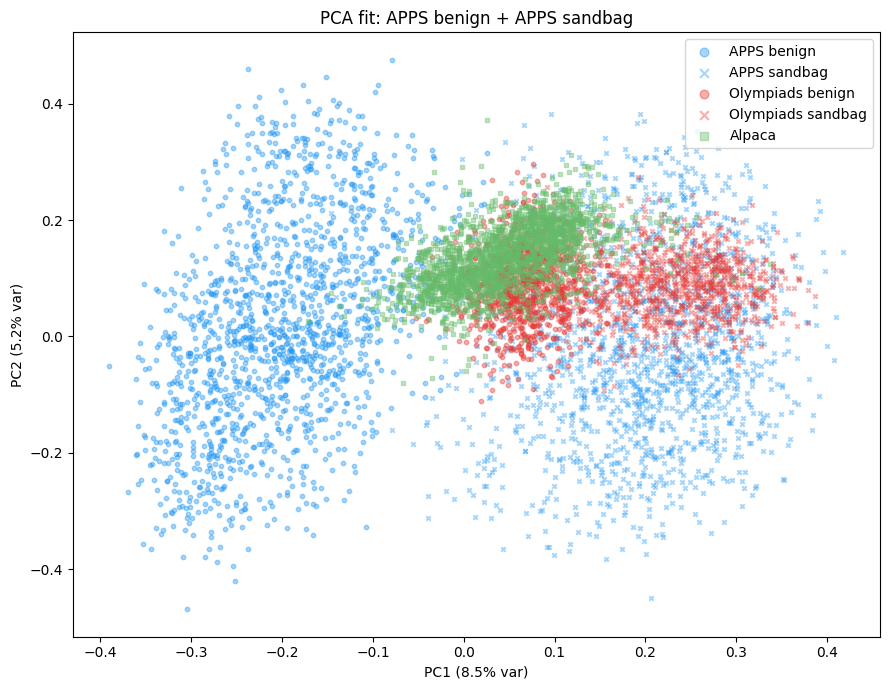

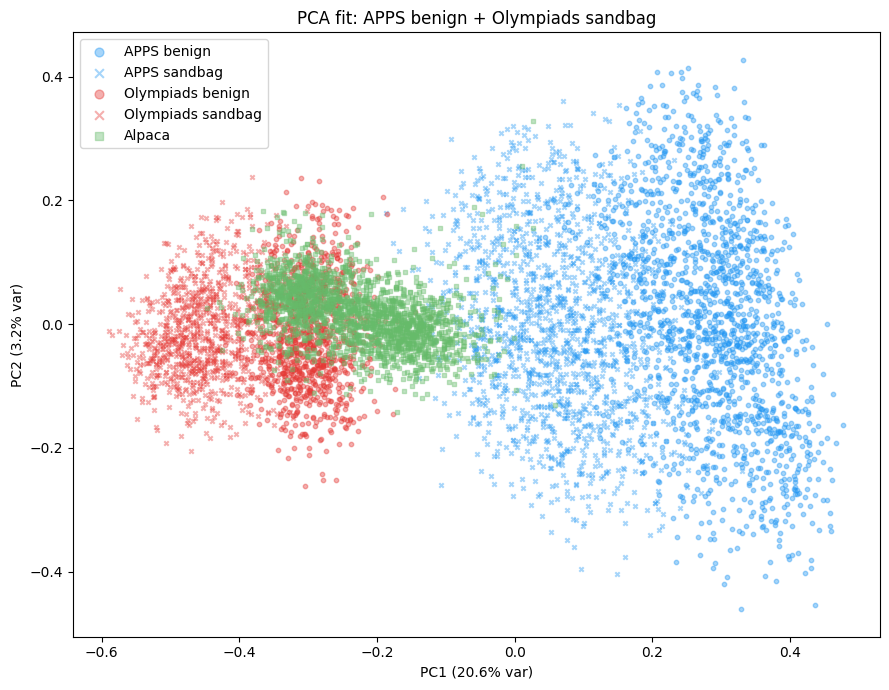

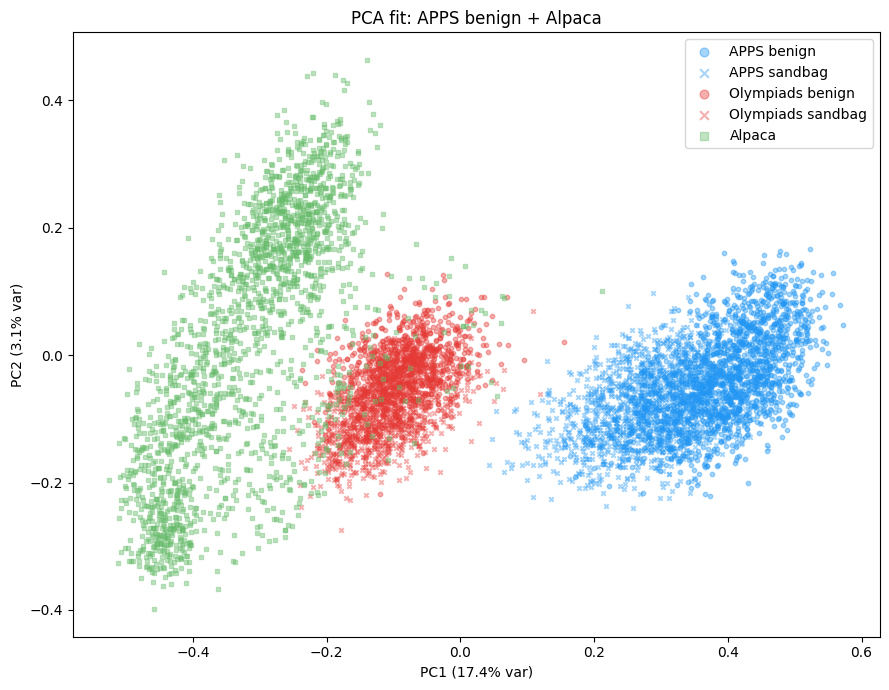

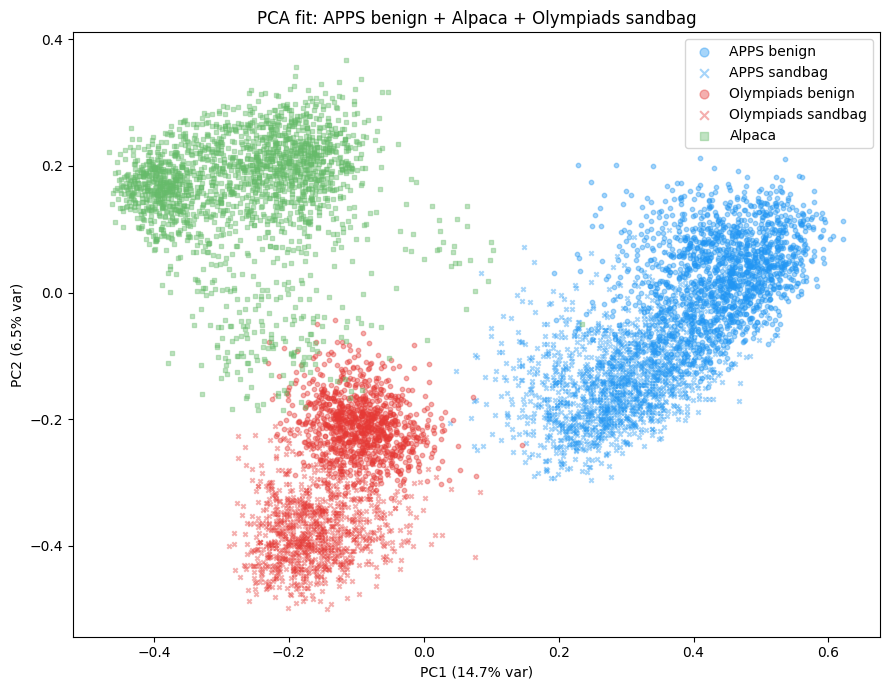

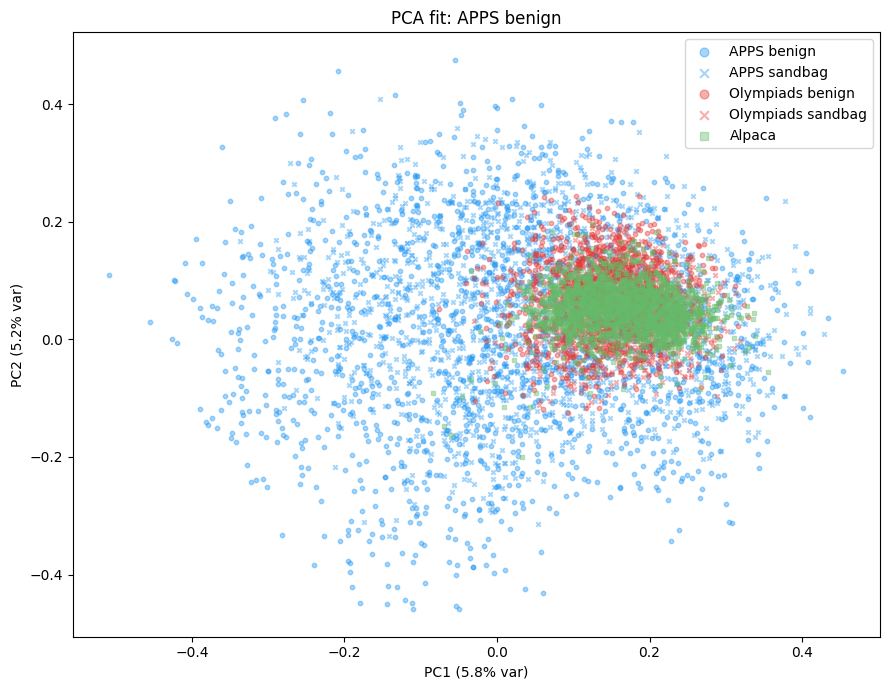

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load all 5 embeddings
emb_dir = 'stored_outputs/embeddings'
apps_benign_emb = np.load(f'{emb_dir}/apps_benign_embeddings.npy')
apps_sandbag_emb = np.load(f'{emb_dir}/apps_sandbag_embeddings.npy')
oly_benign_emb = np.load(f'{emb_dir}/olympiads_benign_embeddings.npy')
oly_sandbag_emb = np.load(f'{emb_dir}/olympiads_sandbag_embeddings.npy')
alpaca_emb = np.load(f'{emb_dir}/alpaca_embeddings.npy')

# Color by BEHAVIOR (sandbag vs benign), shape by dataset
datasets = [
    ('APPS benign',       apps_benign_emb,   '#2196F3', 'o'),   # blue
    ('APPS sandbag',      apps_sandbag_emb,   '#2196F3', 'x'),   # red
    ('Olympiads benign',  oly_benign_emb,     '#E53935', 'o'),   # blue diamond
    ('Olympiads sandbag', oly_sandbag_emb,    '#E53935', 'x'),   # red diamond
    ('Alpaca',            alpaca_emb,         '#66BB6A', 's'),   # green square
]

def plot_all(pca, title):
    fig, ax = plt.subplots(figsize=(9, 7))
    for name, emb, color, marker in datasets:
        proj = pca.transform(emb)
        ax.scatter(proj[:, 0], proj[:, 1], s=10, alpha=0.4,
                   color=color, marker=marker, label=name)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax.set_title(title)
    ax.legend(markerscale=2)
    plt.tight_layout()
    plt.show()

# --- Plot 1: PCA fit on APPS benign + APPS sandbag ---
pca0 = PCA(n_components=2)
pca0.fit(np.vstack([apps_benign_emb, apps_sandbag_emb]))
plot_all(pca0, 'PCA fit: APPS benign + APPS sandbag')

# --- Plot 2: PCA fit on APPS benign + Olympiads sandbag ---
pca1 = PCA(n_components=2)
pca1.fit(np.vstack([apps_benign_emb, oly_sandbag_emb]))
plot_all(pca1, 'PCA fit: APPS benign + Olympiads sandbag')

# --- Plot 3: PCA fit on APPS benign + Alpaca ---
pca2 = PCA(n_components=2)
pca2.fit(np.vstack([apps_benign_emb, alpaca_emb]))
plot_all(pca2, 'PCA fit: APPS benign + Alpaca')

# --- Plot 4: PCA fit on APPS benign + Alpaca + Olympiads sandbag ---
pca3 = PCA(n_components=2)
pca3.fit(np.vstack([apps_benign_emb, alpaca_emb, oly_sandbag_emb]))
plot_all(pca3, 'PCA fit: APPS benign + Alpaca + Olympiads sandbag')

pca4 = PCA(n_components=2)
pca4.fit(apps_benign_emb)
plot_all(pca4, 'PCA fit: APPS benign')
